# "Knowledge Distillation for Traffic Sign Recognition"
> "This is the second part of the post ResNet for Traffic Sign Classification With PyTorch, in which we will try to get close to the results of the previous model but with a smaller one. To do so we will apply the knowledge distillation technique, want to know more? Let's dive in!"

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [knowledgeDistillation, fastai, computer vision]
- image: images/compress.jpg

![](my_icons/traffic/compress.jpg)

# Introduction
It seems that the current trend in Deep Learning is to have bigger and more models. This makes it difficult for users to use them, fit them into small devices, get fast results etc. This is why I see model compression, knowledge distillation, and these kinds of techniques as one of the more interesting and useful topics in deep learning. After all, if you want to apply deep learning in VR/AR you need to fit them into small devices. Also for simulations and computer graphics is better to have optimized and fast models. In addition, this makes AI more affordable to everyone, democratizing access to this technology. <br>
With this objective in mind I tried to get similar results as in my [previous post](https://xanaga.github.io/posts_en/fastai/computer%20vision/traffic%20sign/2022/04/21/ResNet_for_Traffic_Sign_Classification_With_PyTorch.html), but using a resnet18 instead of a resnet34. Before continuing reading this post I encourage you to take a look at the previous one. Nevertheless, I was not successful at all. Looking for some solutions I discovered [FasterAI](https://nathanhubens.github.io/fasterai/) by [Nathan Hubens](https://github.com/nathanhubens), which is an awesome library that implements those compression techniques based on Fastai.<br>
So my objectives with this notebook are:


*   Try to implement Knowledge Distillation technique using FasterAI to start getting familiar with the library. I would like to apply this model compression to other projects too (but that will not be covered in this notebook)
*   Encourage anyone who is thinking about implementing these types of approaches that may seem complicated to try this library.


# Imports

First we will upgrade the fastai version used in Colab, by deafult it is the first version.

In [ ]:
! pip install -Uqq fastai   # upgrade fastai on colab

In [ ]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import fastai
fastai.__version__

'2.5.6'

In [ ]:
from fastai.imports import *
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.data.all import *
from fastai.vision.core import PILImage
from PIL import ImageOps

import matplotlib.pyplot as plt
import csv
from collections import defaultdict, namedtuple
import os
import shutil

import pandas as pd

from sklearn.metrics import confusion_matrix, f1_score

import torch

We will use the following variable to tell Pytorch to allocate the tensors into the GPU if we have access to one. If not, all the processing will be made on the CPU (NOT recommended, it will be very slow)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Download the datasets

This will be analogous to the Download section in the previous post. Despite that, I have added the possibility to only train on some classes of the dataset. Because of using Knowledge Distillation we should be able to classify signals that never have been seen in the training set (or at least give an informed guess). For this notebook, we will use all the classes, but you are encouraged to try to eliminate some and see how it behaves!

> Warning: Check the download links in case the dataset has been moved. For example, the links provided in Pavel's blog post are no longer working. You can find all the versions released [here](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html).

In [ ]:
# We select a subset of the problem (or complete)

c=list(range(43)) # List the classes you want to train on

In [ ]:
#collapse

# Download and unpack the training set and the test set

! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip -P data
! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip -P data
! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip -P data
! unzip data/GTSRB_Final_Training_Images.zip -d data
! unzip data/GTSRB_Final_Test_Images.zip -d data
! unzip data/GTSRB_Final_Test_GT.zip -d data

# Move the test set to data/test

! mkdir data/test
! mv data/GTSRB/Final_Test/Images/*.ppm data/test

# Download class names
! wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv -P data

The following are some functions and code used to organize and divide our data into training, validation and test set. It is analogous to the process made in the resnet34 notebook, with some minor changes to handle the cases where not all the classes are selected. A more detailed explanation can be found in the [previous post](https://xanaga.github.io/posts_en/fastai/computer%20vision/traffic%20sign/2022/04/21/ResNet_for_Traffic_Sign_Classification_With_PyTorch.html). 

We have changed the `read_annotations` function to allow us to filter and read only the annotations of the classes we are interested in. This is done by adding the `if` inside the `for` loop. So the *classes* will have to be passed as an argument in all the following functions.

In [ ]:
Annotation = namedtuple('Annotation', ['filename', 'label'])

def read_annotations(filename, classes=None):
    annotations = []

    with open(filename) as f:
        reader = csv.reader(f, delimiter=';')
        next(reader) # skip header

        # loop over all images in current annotations file
        for row in reader:
            filename = row[0] # filename is in the 0th column
            label = int(row[7]) # label is in the 7th column
            if classes is None or label in classes: # We only read the annotations of the classes we are interested
              annotations.append(Annotation(filename, label)) 
            
    return annotations


def load_training_annotations(source_path, classes=None):
    annotations = []
    for c in range(0,43):
        filename = os.path.join(source_path, format(c, '05d'), 'GT-' + format(c, '05d') + '.csv')
        annotations.extend(read_annotations(filename, classes))
    return annotations


def copy_files(label, filenames, source, destination, classes=None, move=False):
    func = os.rename if move else shutil.copyfile
    
    label_path = os.path.join(destination, str(label))
    if not os.path.exists(label_path):
        os.makedirs(label_path)
        
    for filename in filenames:
        if classes is None or int(os.path.basename(label_path)) in classes:
          destination_path = os.path.join(label_path, filename)
          if not os.path.exists(destination_path):
              func(os.path.join(source, format(label, '05d'), filename), destination_path)


def split_train_validation_sets(source_path, train_path, validation_path, all_path, classes, validation_fraction=0.2):
    """
    Splits the GTSRB training set into training and validation sets.
    """
    
    if not os.path.exists(train_path):
        os.makedirs(train_path)
        
    if not os.path.exists(validation_path):
        os.makedirs(validation_path)
        
    if not os.path.exists(all_path):
        os.makedirs(all_path)
    
    annotations = load_training_annotations(source_path)
    filenames = defaultdict(list)
    for annotation in annotations:
        filenames[annotation.label].append(annotation.filename)

    for label, filenames in filenames.items():
        filenames = sorted(filenames)
        
        validation_size =int(len(filenames) // 30 * validation_fraction) * 30
        train_filenames = filenames[validation_size:]
        validation_filenames = filenames[:validation_size]
        
        copy_files(label, filenames, source_path, all_path, classes, move=False)
        copy_files(label, train_filenames, source_path, train_path, classes, move=True)
        copy_files(label, validation_filenames, source_path, validation_path, classes, move=True)

Due to the changes we have made in the previous functions we only have to add the information about the classes in the last step, passing it to the `split_train_validation_sets` function.

In [ ]:
path = 'data'
source_path = os.path.join(path, 'GTSRB/Final_Training/Images')
train_path = os.path.join(path, 'train')
validation_path = os.path.join(path, 'valid')
all_path = os.path.join(path, 'all')
validation_fraction = 0.2
split_train_validation_sets(source_path, train_path, validation_path, all_path, c, validation_fraction)

test_annotations = read_annotations('data/GT-final_test.csv')

# Prepare the data

Data preparation is even more similar to the [previous post](https://xanaga.github.io/posts_en/fastai/computer%20vision/traffic%20sign/2022/04/21/ResNet_for_Traffic_Sign_Classification_With_PyTorch.html). We will only add a *vocab* when creating the dataset. This is because if we don't specify it Fastai will take as *vocab* the classes that appear in our data, which would be problematic if we want to restrict the problem to only a subset of classes.

In [ ]:
# class_names wil be a dictionary of the class name and its label

classes = pd.read_csv('data/signnames.csv')
class_names = {}
for i, row in classes.iterrows():
    class_names[str(row[0])] = row[1]

In [ ]:
sz = 96
data = ImageDataLoaders.from_folder(path, item_tfms=[Resize(sz,order=0)], bs=256, 
                                    batch_tfms=[*aug_transforms(do_flip=False,
                                                              max_zoom=1.2,
                                                              max_rotate=10,
                                                              max_lighting=0.8,
                                                              p_lighting=0.8),
                                                Normalize.from_stats(*imagenet_stats)],
                                    vocab=[str(i) for i in range(43)])

We can see that our *vocab* will have all the classes, no matter which classes we use to train.

In [ ]:
data.vocab

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']

In [ ]:
#hide

len(data.train_ds), len(data.valid_ds)

(31919, 7290)

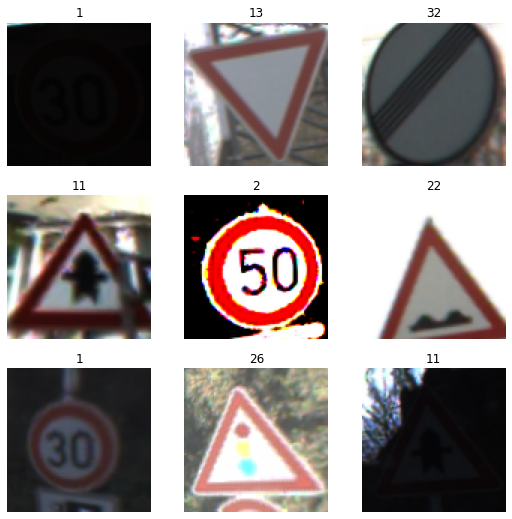

In [ ]:
#hide

data.show_batch(nrows=3, ncols=3)

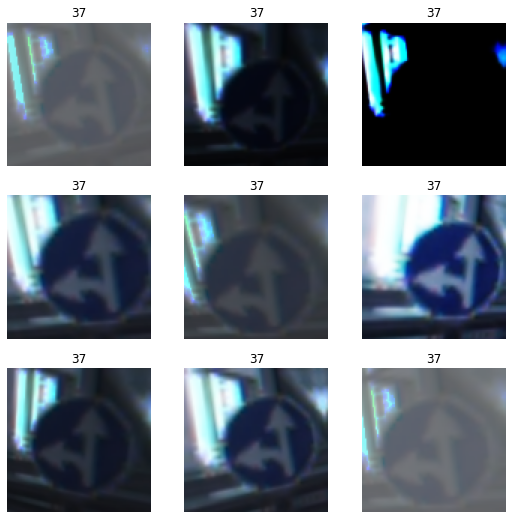

In [ ]:
#hide
data.show_batch(nrows=3, ncols=3,unique=True)

# Knowledge Distillation

This is a technique proposed by Geoffrey E. Hinton as a way to extract the knowledge from big models and use it to train simpler architectures. Moreover, it also has proven to provide what seems to be more robust and general learning which is always desirable. We have considered this approach because of the increasing size of the models not only in computer vision tasks but also in Natural Language Processing (NLP), which makes those difficult to be used in inference for very time demanding tasks or even impossible to fit in embedded systems. 

The **high-level idea** is to, instead of training the models with one-hot encoded vectors, train them using a “softer version” of those that stores some information about the similarity between images. Is a concept similar to word embeddings in NLP.  These labels are obtained from (normally) a bigger model which is already trained and used only for inference. 

Here is where we start using **FasterAI** library. Nevertheless, I found problems loading a model into a learner with Fastai. As `KnowledgeDistillation` function expects to receive a learner I had to copy and paste this function and modify it by adding the `from_learner` parameter. In this way, I can set it to false and use as a teacher a plain PyTorch model. Nevertheless, the correct way of using it would be as straightforward as installing the library:

`pip install fasterai`

And import the things you need:

`from fasterai import ...`

In [ ]:
#hide

class KnowledgeDistillation(Callback):
    def __init__(self, teacher, loss, from_learner=True):
        store_attr()

    def after_loss(self):
        teacher_model = self.teacher.model if self.from_learner else self.teacher
        teacher_model.eval() #don't propagate gradients
        teacher_output = teacher_model(self.x)
        new_loss = self.loss(self.pred, self.y, teacher_output, student=self.learn.model, teacher=teacher_model)
        self.learn.loss_grad = new_loss
        self.learn.loss = self.learn.loss_grad.clone()

def SoftTarget(y, labels, teacher_scores, T=20, α=0.7, **kwargs): 
    return nn.KLDivLoss(reduction='batchmean')(F.log_softmax(y/T, dim=-1), 
                                               F.softmax(teacher_scores/T, dim=-1)) * (T*T * 2.0 * α) + F.cross_entropy(y, labels) * (1. - α)


In [ ]:
sz = 96
bs = 256
wd = 5e-3
f1_score_mult = FBeta(beta=1, average='weighted')

To act as the teacher we will use the model we trained in the [previous post](https://xanaga.github.io/posts_en/fastai/computer%20vision/traffic%20sign/2022/04/21/ResNet_for_Traffic_Sign_Classification_With_PyTorch.html) which can be found in this [repo](https://github.com/XanaGA/models/tree/master/traffic). You can download it from there or train your own model using the previous notebook. Once you have the model trained you will have to set the `path_to_model` variable.

If you are working in Colab you can drag and drop the model into the Colab's file explorer or save the model in your drive and mount it (just by clicking the *Mount Drive* button in the *files* tab, on the left in Colab). By mounting the drive you will be able to reach the model file by navigating across your drive directories.

In [ ]:
path_to_model = #your_path

## The teacher model 💼 📏


First, we prepare the teacher model. To do so, we will get the architecture of our model with random weights and then we will fill it with the trained weights.

> Important: To do that, is necessary that the *random filled architecture* has exactly the same parameters as the ones in the *pretrained* ones.

This is why we use `create_cnn_model` fuction of Fastai, which given a model architecture it creates a model (which is a Sequential object) with the head and the body that we choose. In the previous notebook we created the Learner with the default settings, so now we will use those defaults too. For each architecture, Fastai has a way of cutting the model, and for all of them it uses the same default head, you can check the [source code](https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L138)! 

If you would want to create the model with a different head and body you would have to use the `cut` and `custom_head` arguments. You can find more information about it in the [documentation](https://docs.fast.ai/vision.learner.html#create_cnn_model).

The `to_device` method will place it into GPU or CPU depending on the hardware available.

In [ ]:
#collapse_output

teacher = create_cnn_model(resnet34, 43, pretrained=False).to(device) #get the model architecture
teacher.load_state_dict(torch.load(path_to_model+'resnet34_weights.pth')) #load the trained wheights
teacher

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

> Note: The `teacher` is a Sequential object with two modules. The module `(0)` is the **body**, and it is the original architecture of the model (in our case resnet34), which can be pretrained (not in our case). The second module, the `(1): Sequential`, is the **head** which is initialized using `kaiming_normal` initialization by default(it can be changed using the `init` argument), so it is not pretrained. The layers of this **head** are the default used in Fastai. The decision about where to *cut* the original model is taken according to Fastai metadata for each architecture, but as we have said it is customizable using the `cut` argument.

Our teacher model is almost ready! The only thing that last is that, as we don't want to propagate gradients through our teacher (we only want it for inference) we should make sure it is frozen.

The following PyTorch code does exactly that.

In [ ]:
for param in teacher.parameters():
    param.requires_grad = False

> Note: Inside the `KnowledgeDistillation` callback we use the teacher in `eval()` mode, so the gradients would not be calculated even if the model is not frozen, but is better to make sure.

## The student Learner 📗  

Now let's prepare our student network. As before we use the `create_cnn_model`, but with a pretrained resnet18 architecture, to build the model that we will pass to the Learner constructor.


In [ ]:
student_model=create_cnn_model(resnet18, 43).to(device) #get the model architecture and pretrained wheights

Then, we could do the following:

In [ ]:
#collapse_output

bad_student = Learner(data, student_model, metrics=[accuracy,f1_score_mult])
bad_student.summary()

Sequential (Input shape: 256 x 3 x 96 x 96)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 64 x 48 x 48  
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     256 x 64 x 24 x 24  
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                       

But this would unfreeze the whole student! We don't want that, we would like to have the earlier pretrained layers of the model (the **body**) frozen and the rest (the **head**) to be trainable. The reason is that, by default, `Learner` does not freeze any parameter group. 

So let's freeze the body. To do that we use the `freeze_to(n)` method where **n** is the number of parameter groups we want to freeze. We take n=1 as we only want the body to be frozen.

In [ ]:
#collapse_output

bad_student.freeze_to(1)

bad_student.summary()

/usr/local/lib/python3.7/dist-packages/fastai/optimizer.py:22: UserWarning: Freezing 1 groups; model has 1; whole model is frozen.
  warn(f"Freezing {self.frozen_idx} groups; model has {len(self.param_lists)}; whole model is frozen.")


Sequential (Input shape: 256 x 3 x 96 x 96)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 64 x 48 x 48  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     256 x 64 x 24 x 24  
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                       

Now we have frozen the entire model! 🥶

> Note: The BatchNorm2d layers are never frozen, this is why we have some trainable parameters.

If we look at the warning at the top of the output, we can see the problem. We only have one parameter group which is the entire model.

So, how are those parameters groups chosen? By the argument `splitter`, which by default is `trainable_parameters`. This will return all the trainable parameters of the model. In our case, they are all trainable, so we will only get one parameter group, hence the whole student will be frozen. 

The solution is to pass `splitter=default_split`. This will split the parameter groups in body and head, just as we want!

> Important: In the **Explore Training** section we will use `lr_find()`, which does not accept any *weight decay* nor  *callback* arguments (it takes the ones defined when creating the Learner). Then the correct thing to do is to pass as an argument to the learner the `KnowledgeDistillation` callback, as we do with the *weight decay*. By doing so we have thesame training scenario when doing  `lr_find()` and `fit_one_cycle()`.

In [ ]:
loss = partial(SoftTarget, T=20)
kd = KnowledgeDistillation(teacher, loss, from_learner=False)

In [ ]:
#collapse_output

student = Learner(data, student_model, metrics=[accuracy,f1_score_mult], splitter=default_split, wd=wd, cbs=kd)
student.freeze_to(1)
#student.summary()

> Warning: If you use `student.summary()` it will raise the following error:
*Exception occured in `KnowledgeDistillation` when calling event `after_loss`:
  cross_entropy_loss(): argument 'target' (position 2) must be Tensor, not NoneType.*
Although, it only affect to the summary method. So we can continue and if we really want to check the learner we can remove and add back the callback, as the collapsed code shows below.


In [ ]:
#collapse

print('See in which position the KnowledgeDistillation is:')
print(student.cbs)
print()

student.remove_cb(cb=student.cbs[3]) # We could also do cb=kd

print(student.summary()) # Obviously you won't see the KnowledgeDistillation callback at the end

student.add_cb(cb=kd) # Add back the callback

print()
print('Check that you have the same list as before the summary:')
print(student.cbs)

See in which position the KnowledgeDistillation is:
[TrainEvalCallback, Recorder, ProgressCallback, KnowledgeDistillation]



Sequential (Input shape: 256 x 3 x 96 x 96)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 64 x 48 x 48  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     256 x 64 x 24 x 24  
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                       

# Training

In the training process is where **FasterAI** magic comes in 🧙

Only by adding the `KnowledgeDistillation` callback when fitting the model, we will be able to use this technique with almost the same code as in the [previous post](https://xanaga.github.io/posts_en/fastai/computer%20vision/traffic%20sign/2022/04/21/ResNet_for_Traffic_Sign_Classification_With_PyTorch.html). But, as we setted those parameters when creating the `Learner()`, we don't even need to do that!🎉

## Explore training

We will follow the same procedure as is the [previous post](https://xanaga.github.io/posts_en/fastai/computer%20vision/traffic%20sign/2022/04/21/ResNet_for_Traffic_Sign_Classification_With_PyTorch.html) for finding the hyperparameters that better train our model.

> Warning: The following code cells aim to illustrate the procedure of how to find a good learning rate. In practice we made more experiments, so you are encouraged to change the values in these cells to see how the training behaves. Don't be afraid to overfit as this will not be the final model. You can set a large number of iterations to see when it starts overfitting so you can train the final model in a more informed way in the next section.

> Note: Remember that the *weight decay* and the *Knowledge Distillation Callback* where setted in the `Learner()` definition.

SuggestedLRs(valley=0.004365158267319202)

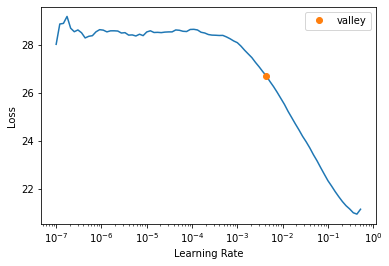

In [ ]:
student.lr_find() # wd and callback included

In [ ]:
student.fit_one_cycle(1, lr_max=0.001) # wd and cbs are setted in Learner()

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,15.465137,13.668188,0.605898,0.563930,01:35


In [ ]:
#collapse-output

student.unfreeze()

SuggestedLRs(valley=0.00019054606673307717)

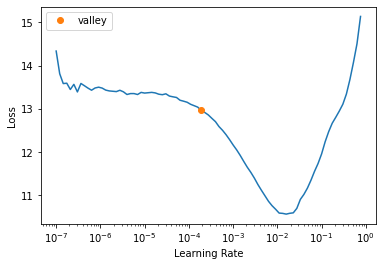

In [ ]:
student.lr_find()

In [ ]:
student.fit_one_cycle(9, lr_max=slice(0.0001, 0.001)) #, wd=wd, cbs=kd)

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,9.225066,6.410910,0.833745,0.821246,01:41
1,4.279030,1.822614,0.960905,0.957461,01:36
2,2.453992,1.222131,0.974760,0.972952,01:37
3,1.889181,0.925809,0.982579,0.981159,01:37
4,1.645638,0.775705,0.988889,0.988514,01:37
5,1.506031,0.679071,0.989575,0.989230,01:37
6,1.422567,0.668275,0.990809,0.990585,01:36
7,1.355428,0.612182,0.991632,0.991374,01:36
8,1.323943,0.623958,0.991495,0.991259,01:37


SuggestedLRs(valley=1.5848931980144698e-06)

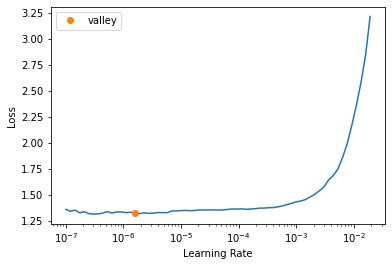

In [ ]:
student.lr_find()

In [ ]:
student.fit_one_cycle(6, lr_max=slice(0.00001, 0.0001))#, wd=wd, cbs=kd)

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,1.322057,0.606176,0.991770,0.991487,01:37
1,1.320874,0.618872,0.990535,0.990247,01:36
2,1.300413,0.615932,0.992730,0.992584,01:36
3,1.300726,0.611663,0.992455,0.992312,01:36
4,1.290397,0.592799,0.992455,0.992310,01:37
5,1.286910,0.597255,0.992455,0.992296,01:37


## Retrain on the whole dataset

Once we know which configuration is better we can train the model on all the data available (training+validation).

In [ ]:
data = ImageDataLoaders.from_folder(path, item_tfms=[Resize(sz,order=0)], bs=256, 
                                    batch_tfms=[*aug_transforms(do_flip=False,
                                                              max_zoom=1.2,
                                                              max_rotate=10,
                                                              max_lighting=0.8,
                                                              p_lighting=0.8),
                                                Normalize.from_stats(*imagenet_stats)],
                                    vocab=[str(i) for i in range(43)], train='all')

In [ ]:
teacher = create_cnn_model(resnet34, 43, pretrained=False).to(device)
teacher.load_state_dict(torch.load(path_to_model+'resnet34_weights.pth'))

student_model=create_cnn_model(resnet18, 43).to(device)
student = Learner(data, student_model, metrics=[accuracy,f1_score_mult], splitter=default_split, wd=wd, cbs=kd)
student.freeze_to(1)

In [ ]:
student.fit_one_cycle(1, lr_max=0.001)

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,13.978484,11.242065,0.715364,0.683073,01:49


In [ ]:
student.unfreeze()
student.fit_one_cycle(10, lr_max=slice(0.0001, 0.001))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,9.187653,5.441027,0.893416,0.883363,01:54
1,3.874919,1.078969,0.987106,0.987011,01:53
2,2.228036,0.545888,0.997257,0.997255,01:53
3,1.754988,0.441869,0.998080,0.998076,01:52
4,1.543820,0.505094,0.998903,0.998900,01:53
5,1.451698,0.324294,0.999726,0.999725,01:52
6,1.336454,0.319012,0.999863,0.999863,01:51
7,1.282818,0.278213,1.000000,1.000000,01:51
8,1.239342,0.259717,1.000000,1.000000,01:50
9,1.236298,0.250886,1.000000,1.000000,01:51


In [ ]:
student.fit_one_cycle(6, lr_max=0.0001)

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,1.270205,0.312592,0.999726,0.999725,01:50
1,1.336736,0.343301,0.999863,0.999863,01:51
2,1.285208,0.289410,0.999863,0.999863,01:50
3,1.217801,0.267841,0.999863,0.999863,01:51
4,1.179426,0.231982,1.000000,1.000000,01:51
5,1.172143,0.221064,1.000000,1.000000,01:50


# Test

Like we did in the [previous post](https://xanaga.github.io/posts_en/fastai/computer%20vision/traffic%20sign/2022/04/21/ResNet_for_Traffic_Sign_Classification_With_PyTorch.html) we will use Test Time Augmentations, and we will use the same function to plot how the performance and inference time behave.

> Note: We have added to the `test_time_aug` function  the `mask` argument. This will allow us to compute the F1-score only for some classes. For example, only for the ones we have trained on.

In [ ]:
def test_time_aug(learner, test_dataloader, y_true, metric, n_augs=[10], beta=0.1,mask=None):
    res = []
    if mask is None:
      mask=list(range(len(y_true)))

    learner.eval()

    for aug in n_augs:

      if aug == 0:
        start = time.time()
        log_preds,_ = learner.get_preds(dl=test_dataloader)
        end = time.time()
        infer_time = end-start
      else:
        start = time.time()
        log_preds,_ = learner.tta(dl=test_dataloader, n=aug, beta=beta)
        end = time.time()
        infer_time = end-start

      preds = np.argmax(log_preds,1)
      score = metric(preds[mask], y_true[mask])

      res.append([aug, score,infer_time])

      print(f'N Augmentations: {aug}\tF1-score: {score}\tTime:{infer_time}')

    return pd.DataFrame(res, columns=['n_aug', 'score', 'time'])

In [ ]:
true_test_labels = {a.filename: a.label for a in test_annotations}
class_indexes = data.vocab.o2i
test_img=get_image_files('./data/test')
filenames = [filepath.name for filepath in test_img]
labels = [str(true_test_labels[filename]) for filename in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [ ]:
test_dataloader=data.test_dl(test_img, bs=256, shuffle=False)

The following code will create the mask used for computing the F1-score. You only have to specify in which classes you want to focus on the `interest_classes` variable. We will focus on all the classes that we trained with (which are all the classes).


In [ ]:
interest_classes=c 
interest_idx=[data.vocab.o2i[str(cl)] for cl in interest_classes]
mask=np.isin(y_true, interest_idx, invert=False)

> Note: If you set `invert` to `True` you will get the F1-score only on the images you have not seen in the training.

If we try to use our learner for as it is we will get an error, produced by the `KnowledgeDistallation` callback. But we don't need it anymore! (sorry Nathan, you've been a hero 😔). Let's remove it.

In [ ]:
student.cbs

(#4) [TrainEvalCallback,Recorder,ProgressCallback,KnowledgeDistillation]

In [ ]:
student.cbs[3]

KnowledgeDistillation

In [ ]:
student.remove_cb(cb=student.cbs[3])
student.cbs

(#3) [TrainEvalCallback,Recorder,ProgressCallback]

In [ ]:
metric = partial(f1_score, average='weighted')

results = test_time_aug(student, test_dataloader, y_true, metric, n_augs=[0, 5, 10, 20, 30])

N Augmentations: 0	F1-score: 0.9922140340549594	Time:24.077036380767822


N Augmentations: 5	F1-score: 0.9933502950176439	Time:117.72993874549866


N Augmentations: 10	F1-score: 0.9943761367605225	Time:212.58393836021423


N Augmentations: 20	F1-score: 0.9950922306435893	Time:405.470721244812


N Augmentations: 30	F1-score: 0.9947694889306348	Time:592.3682796955109


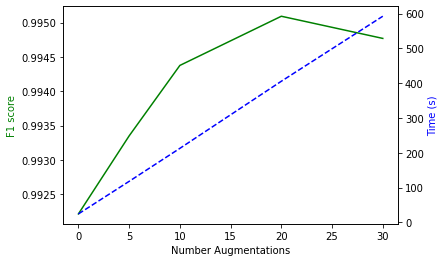

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(results['n_aug'], results['score'], 'g-')
ax2.plot(results['n_aug'], results['time'], 'b--')

ax1.set_xlabel('Number Augmentations')
ax1.set_ylabel('F1 score', color='g')
ax2.set_ylabel('Time (s)', color='b')

plt.show()

# Conclusion

As we have seen Knowledge Distillation allows us to train for more epochs without overfitting and improves the final performance of the model compared with not using it (and getting very close of the resnet34, which resulted in 0.9963 F1-score). An intuitive explanation can be that we are giving more information to the network in every step of the backpropagation by, not only providing one-hot labels, but also a probability of the image to be another class. With this we are introducing the idea of similarities between classes.

I see these types of compression approaches as very interesting and I would like to apply them in other domains, maybe to NLP or 3D data. So I cannot recommend more [FasterAI](https://nathanhubens.github.io/fasterai/) library and infinitely thank the work done to Nathan Hubens. Also, if you want to learn more about how to make smaller and faster Neural Networks I encourage you to visit his [blog](https://nathanhubens.github.io/posts/).

Thanks for reading!😀